In [28]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Hiragino Sans'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as ss
from statsmodels.sandbox.stats import runs
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# E-Mini S&P500先物と金先物データ読み込み

In [2]:
dfsp_tmp = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
dfg_tmp = pd.read_csv(f'data/gold-200626/gold-daily.csv')
dfs = [dfsp_tmp, dfg_tmp]

# datetime indexに変換
def to_datetime_index(df):
    # DateTime列を追加
    df['datetime'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    df = df.set_index('datetime', drop=True)
    df = df.drop(columns=['Date', 'Time'])
    return df

dfs = [to_datetime_index(df) for df in dfs]

# 対数変換した列を追加
def add_log_values(df):
    df['logO'] = np.log(df['Open'])
    df['logH'] = np.log(df['High'])
    df['logL'] = np.log(df['Low'])
    df['logC'] = np.log(df['Close'])
    df['logV'] = np.log(df['Vol'])
    df['logOI'] = np.log(df['OI'])

_ = [add_log_values(df) for df in dfs]

/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 価格、対数価格、価格階差、対数差収益率（100倍）のDFを作成

In [3]:
def to_log_return_ratio_df(df):
    diff_df = df.diff()
    close_df = df[['Close', 'logC']]
    diff_df = diff_df.rename(columns={'Close': 'CloseDiff', 'logC': 'logCDiff'})
    close_diff_df = diff_df[['CloseDiff', 'logCDiff']]
    close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
    rr_df = pd.concat([close_df, close_diff_df], axis=1)
    rr_df = rr_df.dropna()
    return rr_df

rr_dfs = [to_log_return_ratio_df(df) for df in dfs]

# 2019年の1年間のみのデータ

In [4]:
rrdfs2019 = [df[dt.datetime(2019, 1, 1):dt.datetime(2020, 1, 1)] for df in rr_dfs]

In [5]:
rrdfs2019

[                       Close      logC  CloseDiff  logCDiff
 datetime                                                   
 2019-01-02 17:00:00  2513.75  7.829531       5.75  0.002290
 2019-01-03 17:00:00  2450.50  7.804047     -63.25 -0.025484
 2019-01-04 17:00:00  2534.00  7.837554      83.50  0.033507
 2019-01-07 17:00:00  2553.25  7.845122      19.25  0.007568
 2019-01-08 17:00:00  2575.25  7.853702      22.00  0.008580
 ...                      ...       ...        ...       ...
 2019-12-24 17:00:00  3214.50  8.075427      -1.50 -0.000467
 2019-12-26 17:00:00  3233.25  8.081243      18.75  0.005816
 2019-12-27 17:00:00  3226.25  8.079076      -7.00 -0.002167
 2019-12-30 17:00:00  3212.25  8.074727     -14.00 -0.004349
 2019-12-31 17:00:00  3219.75  8.077059       7.50  0.002332
 
 [252 rows x 4 columns],
                       Close      logC  CloseDiff  logCDiff
 datetime                                                  
 2019-01-02 17:00:00  1359.4  7.214799        2.8  0.002062


# 価格と対数差収益率を比較

## E-Mini S&P500先物

/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '2019年のE-Mini S&P500先物の終値（上）とその対数差収益率（下）')

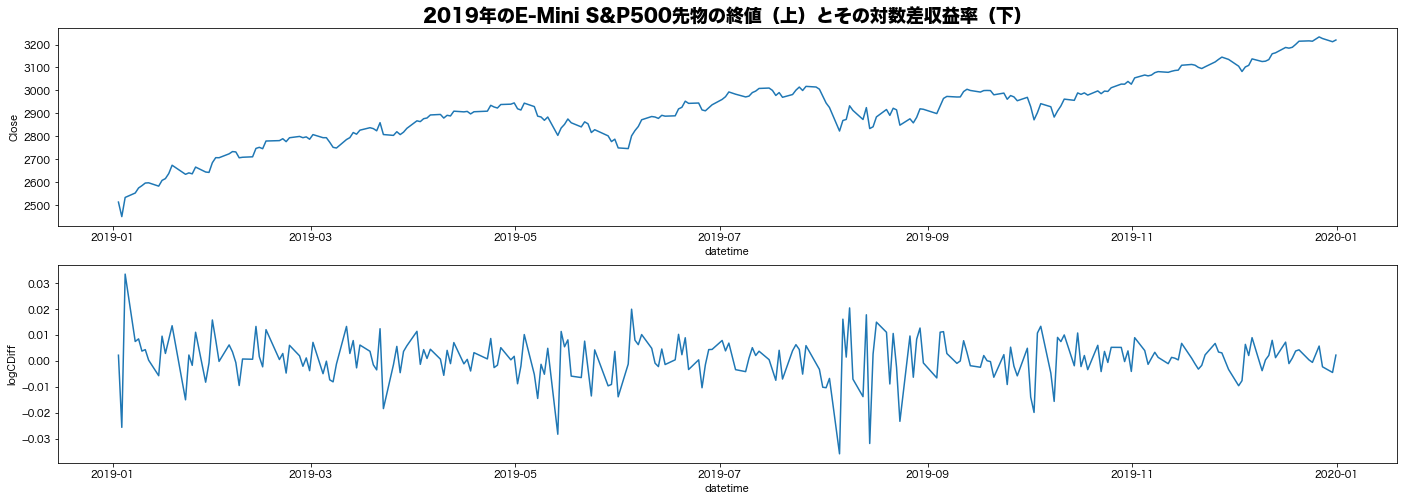

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(24, 8))
sns.lineplot(rrdfs2019[0].index, rrdfs2019[0]['Close'], ax=ax[0])
sns.lineplot(rrdfs2019[0].index, rrdfs2019[0]['logCDiff'], ax=ax[1])
ax[0].set_title('2019年のE-Mini S&P500先物の終値（上）とその対数差収益率（下）', fontsize=18, fontweight='bold')

/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '2019年の金先物の終値（上）とその対数差収益率（下）')

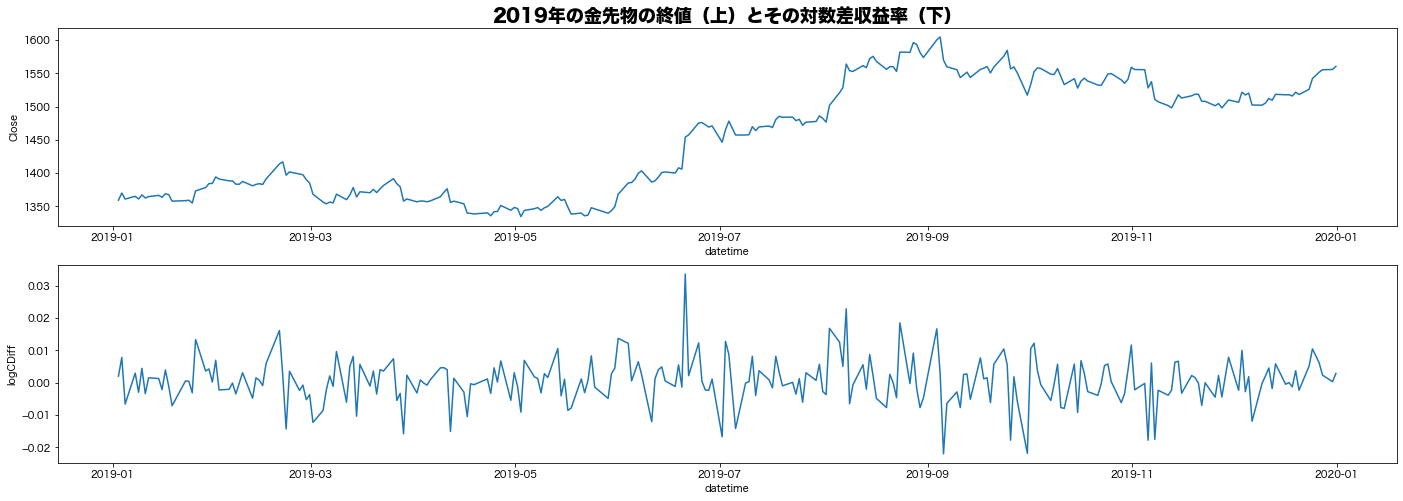

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(24, 8))
sns.lineplot(rrdfs2019[1].index, rrdfs2019[1]['Close'], ax=ax[0])
sns.lineplot(rrdfs2019[1].index, rrdfs2019[1]['logCDiff'], ax=ax[1])
ax[0].set_title('2019年の金先物の終値（上）とその対数差収益率（下）', fontsize=18, fontweight='bold')

# 「過去の値と同じような値が出やすい」かどうか確認する（自己相関の簡易な可視化）

横軸にr(t-1)、縦軸にr(t)を撮った散布図

/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '金先物の自己相関')

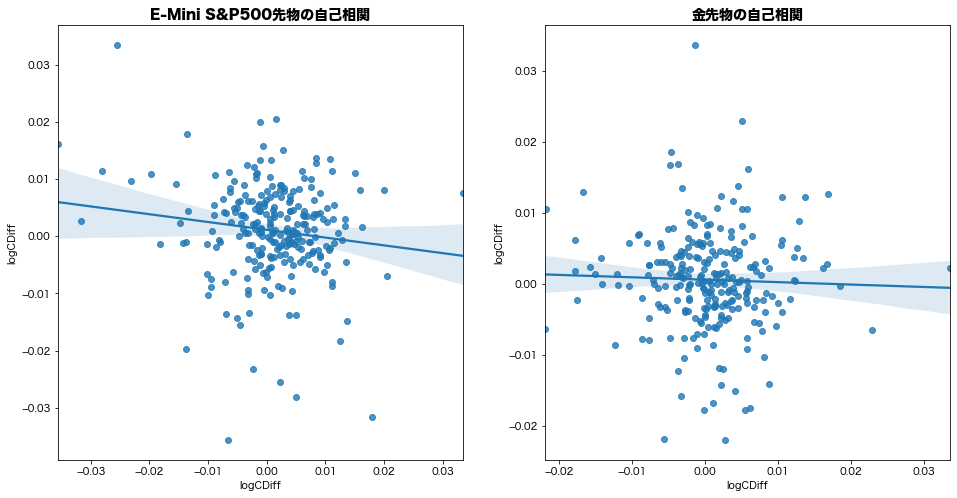

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# S&P
sns.regplot(rrdfs2019[0]['logCDiff'][:-1], rrdfs2019[0]['logCDiff'][1:], ax=ax[0])
ax[0].set_title('E-Mini S&P500先物の自己相関', fontsize=14, fontweight='bold')
# Gold
sns.regplot(rrdfs2019[1]['logCDiff'][:-1], rrdfs2019[1]['logCDiff'][1:], ax=ax[1])
ax[1].set_title('金先物の自己相関', fontsize=14, fontweight='bold')

# 自己相関係数

In [13]:
print(f"S&Pの対数差収益率の自己相関係数：{rrdfs2019[0]['logCDiff'].autocorr(lag=1)}")
print(f"金先物の対数差収益率の自己相関係数：{rrdfs2019[1]['logCDiff'].autocorr(lag=1)}")

S&Pの対数差収益率の自己相関係数：-0.13625431342306507
金先物の対数差収益率の自己相関係数：-0.033964123099191494


# コレログラム（自己相関係数のラグの長さを横軸にとったもの）
statsmodels.api.graphics.tsa.plot_acf

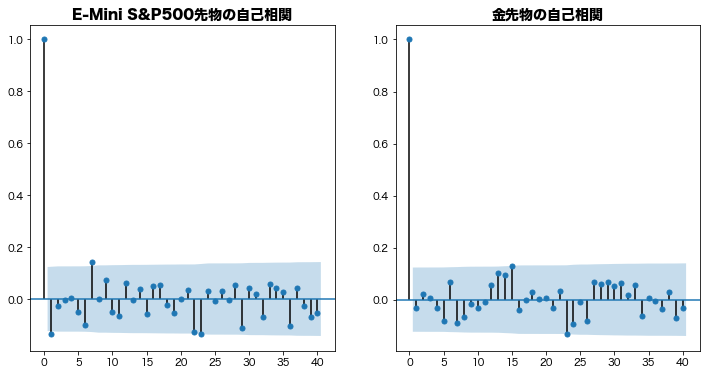

In [26]:
"""
青背景の帯は、自己相関係数が0であるという帰無仮説の元での95%信頼区間を示している（alpha=0.05の時）
39個プロットしているからたまたまこの信頼区間を超えるサンプルが平均で2個出てくるはず
（lag=0は除外）

S&Pでは3個出てきているから平均より多いことになる（したがって信頼区間を超えているサンプルのどれか一つぐらいは本当に自己相関があると言える可能性がある）
金では2個出てきているから平均と同じ。自己相関がないという帰無仮説を棄却できるとは言えない。
"""
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_acf(rrdfs2019[0]['logCDiff'], lags=40, ax=ax[0])
ax[0].set_title('E-Mini S&P500先物の自己相関', fontsize=14, fontweight='bold')
sm.graphics.tsa.plot_acf(rrdfs2019[1]['logCDiff'], lags=40, ax=ax[1])
ax[1].set_title('金先物の自己相関', fontsize=14, fontweight='bold')
plt.show()

# 偏自己相関係数をプロット（partial autocorrelation）
statsmodels.api.graphics.tsa.plot_pacf

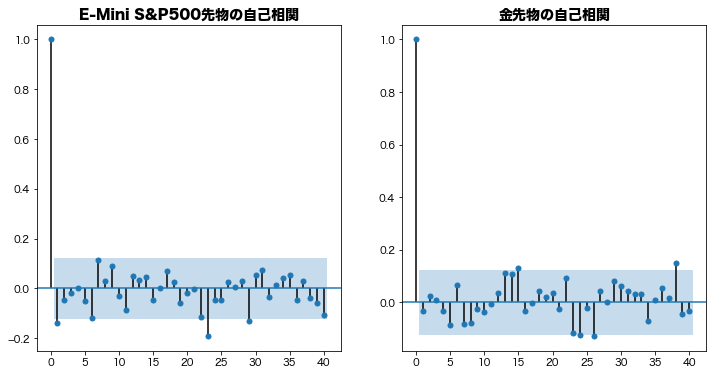

In [27]:
"""
青背景の帯は、偏自己相関係数が0であるという帰無仮説の元での95%信頼区間を示している（alpha=0.05の時）
39個プロットしているからたまたまこの信頼区間を超えるサンプルが平均で2個出てくるはず
（lag=0は除外）

S&Pでは3個出てきているから平均より多いことになる（したがって信頼区間を超えているサンプルのどれか一つぐらいは本当に自己相関があると言える可能性がある）
金では4個出てきているから平均より多いことになる。したがって本当に自己相関があると言えるラグがありそうだ。
"""

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_pacf(rrdfs2019[0]['logCDiff'], lags=40, ax=ax[0])
ax[0].set_title('E-Mini S&P500先物の自己相関', fontsize=14, fontweight='bold')
sm.graphics.tsa.plot_pacf(rrdfs2019[1]['logCDiff'], lags=40, ax=ax[1])
ax[1].set_title('金先物の自己相関', fontsize=14, fontweight='bold')
plt.show()

# 自己相関関係の仮説検定（Ljung-Box検定）

In [36]:
"""
本に従って有意水準を10%とする

S&P
ラグ=1,2,7,8,9の時に自己相関関係があることになる

金
自己相関関係はない事になる
"""
lbvalues, pvalues = ss.diagnostic.acorr_ljungbox(rrdfs2019[0]['logCDiff'], lags=20)
for i, (lbvalue, pvalue) in enumerate(zip(lbvalues, pvalues)):
    print(f"S&Pの結果　ラグ={i+1:2d}の時のLjung-Box検定のp値：{pvalue}")

lbvalues, pvalues = ss.diagnostic.acorr_ljungbox(rrdfs2019[1]['logCDiff'], lags=20)
for i, (lbvalue, pvalue) in enumerate(zip(lbvalues, pvalues)):
    print(f"金先物の結果　ラグ={i+1:2d}の時のLjung-Box検定のp値：{pvalue}")

S&Pの結果　ラグ= 1の時のLjung-Box検定のp値：0.029583235159553994
S&Pの結果　ラグ= 2の時のLjung-Box検定のp値：0.08512072900616104
S&Pの結果　ラグ= 3の時のLjung-Box検定のp値：0.17661719635113826
S&Pの結果　ラグ= 4の時のLjung-Box検定のp値：0.2933108390397885
S&Pの結果　ラグ= 5の時のLjung-Box検定のp値：0.3517125220222759
S&Pの結果　ラグ= 6の時のLjung-Box検定のp値：0.23105180632447528
S&Pの結果　ラグ= 7の時のLjung-Box検定のp値：0.061541180672007
S&Pの結果　ラグ= 8の時のLjung-Box検定のp値：0.09679163012163225
S&Pの結果　ラグ= 9の時のLjung-Box検定のp値：0.0943245193432794
S&Pの結果　ラグ=10の時のLjung-Box検定のp値：0.11427634482703147
S&Pの結果　ラグ=11の時のLjung-Box検定のp値：0.11944217248961578
S&Pの結果　ラグ=12の時のLjung-Box検定のp値：0.1273441069425063
S&Pの結果　ラグ=13の時のLjung-Box検定のp値：0.17172899852502876
S&Pの結果　ラグ=14の時のLjung-Box検定のp値：0.20648301994924492
S&Pの結果　ラグ=15の時のLjung-Box検定のp値：0.22036945244985795
S&Pの結果　ラグ=16の時のLjung-Box検定のp値：0.24150348311596503
S&Pの結果　ラグ=17の時のLjung-Box検定のp値：0.257370768734473
S&Pの結果　ラグ=18の時のLjung-Box検定のp値：0.30709590348845567
S&Pの結果　ラグ=19の時のLjung-Box検定のp値：0.31958910196359014
S&Pの結果　ラグ=20の時のLjung-Box検定のp値：0.3786986955969373
金先物の結果　ラ

/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)
